In [26]:
using LinearAlgebra
using SparseArrays
using GaussQuadrature
using Plots

In [27]:
function exemplo1()
    α = 1.0
    β = 1.0
    f(x) = -2.0 * α + β * x *(x-1.0)
    u(x) = x * (x - 1.0)
    return α, β, f, u
end
function Exemplo2()
    α = 1.0 
    β = 1.0
    f(x) = (α*π^2 + β) *sin(π*x)
    u(x) = sin(π*x)
    return α, β, f, u
end
function Exemplo3()
    α = 1.0 
    β = 0.0
    f(x) = 8.0
    u(x) = -4.0 * x * (x - 1.0)
    return α, β, f, u
end
function Exemplo4()
    α = 1.0 
    β = 1.0
    f(x) = x
    u(x) = x + (exp(-x) - exp(x)) / (exp(1) - exp(-1))
    return α, β, f, u
end

"Retorna os valores de `α`, `β`, `f` e `u` de acordo com o exemplo escolhido."
function dados_de_entrada(exemplo)
    if exemplo == 1
        return exemplo1()
    elseif exemplo == 2
        return Exemplo2()
    elseif exemplo == 3
        return Exemplo3()
    elseif exemplo == 4
        return Exemplo4()
    else
        error("Exemplo inválido. Escolha 1, 2, 3 ou 4.")
    end
end

dados_de_entrada

In [28]:
"""
Mapeia um ponto `ξ` do intervalo padrão `[-1, 1]` para o intervalo físico
"""
function X(x::Float64, h::Float64, i::Int)
    previous_x = (i - 1) * h
    return previous_x + h*(x + 1)/2
end

function fi_1(psi::Float64)
    return (1 - psi)/2
end

function fi_2(psi::Float64)
    return (1 + psi)/2
end

function d_fi(psi, a)
    if a == 1
        return -1.0 / 2.0
    elseif a == 2
        return 1.0 / 2.0
    else
        error("a deve ser 1 ou 2.")
    end
end



d_fi (generic function with 1 method)

## Calculo das matrizes LG e EQ a partir do número de elementos

In [29]:
function make_LG(ne::Int) :: Matrix{Int}
    return transpose(hcat(1:ne, 2:ne+1))
end

function make_EQ(ne::Int) :: Tuple{Int,Vector{Int}}
    m = ne - 1         
    EQ = vcat(m+1,1:m,m+1)
    return m, EQ
end

make_EQ (generic function with 1 method)

## Cálculo da matriz local $K^e$ - via quadratura gaussia

In [30]:

function make_Ke(alfa::Float64, beta::Float64, h::Float64, npg::Int=2)
    P, W = legendre(npg)
    K = zeros(2, 2)
    c1 = 2*alfa/h
    c2 = beta*h/2

    for a in 1:2
        for b in 1:2
            for j in 1:npg
                K[a, b] += W[j] * (d_fi(P[j], a) * d_fi(P[j], b) * c1 + fi_1(P[j]) * fi_2(P[j]) * c2)
            end
        end
    end

    return K
end

make_Ke (generic function with 2 methods)

## Montagem da matriz global K a partir da matriz local $K^e$

In [31]:
function make_K(alfa::Float64, beta::Float64, ne::Int, m::Int, EQoLG::Matrix{Int})
    h = 1.0 / ne
    K = spzeros(m+1, m+1)
    Ke = make_Ke(alfa, beta, h)

    for e in 1:ne
        for a in 1:2
            i = EQoLG[a, e]
            for b in 1:2
                K[i, EQoLG[b, e]] += Ke[a, b]
            end
        end
    end

    return K[1:m, 1:m]
end

make_K (generic function with 1 method)

## Cálculo do vetor local $F^e$ - via quadratura gaussiana

In [32]:
function make_Fe(f::Function, h::Float64, e::Int, P::Vector{Float64}, W::Vector{Float64}, npg::Int=5)
    Fe = zeros(2)     
    for a in 1:2
        for j = 1:npg
            x = X(P[j], h, e)
            Fe[a] += W[j] * f(x) * fi_1(P[j]) * h/2
        end
    end
    
    return Fe
end

make_Fe (generic function with 2 methods)

## Montagem do vetor global F a partir do vetor local $F^e$


In [33]:
function make_F(f::Function, ne::Int, m::Int, EQoLG::Matrix{Int}, npg::Int=5)
    h = 1.0 / ne
    F = zeros(m + 1)
    P, W = legendre(npg)
    
    for e in 1:ne
        Fe = make_Fe(f, h, e, P, W, npg)
        for a = 1:2
            F[EQoLG[a, e]] += Fe[a]
        end
    end
    
    return F[1:m]
end

make_F (generic function with 2 methods)

In [34]:
function calculate_error(C::Vector{Float64}, u::Function, X::Function, fi_1::Function, fi_2::Function, P::Array{Float64}, W::Array{Float64}, npg::Int, ne::Int, h::Float64)
    error = 0
    c_ = [0; C; 0]
    for e in 1:ne
        for j in 1:npg
            point = X(P[j], h, e)
            phi_1 = fi_1(P[j])
            phi_2 = fi_2(P[j])
            error += W[j] * ( u(point) - c_[e]*phi_1 - c_[e+1]*phi_2 )^2
        end
    end
    return sqrt(h*error/2)
end

calculate_error (generic function with 1 method)

## Comparando a solução aproximada com a solução exata


"ne = "

4

"LG = "

2×4 Matrix{Int64}:
 1  2  3  4
 2  3  4  5

"m = "

3

"EQ = "

5-element Vector{Int64}:
 4
 1
 2
 3
 4

"EQoLG = "

2×4 Matrix{Int64}:
 4  1  2  3
 1  2  3  4

"Matriz K:"

3×3 SparseMatrixCSC{Float64, Int64} with 7 stored entries:
  8.0  -4.0    ⋅ 
 -4.0   8.0  -4.0
   ⋅   -4.0   8.0

"Vetor F:"

3-element Vector{Float64}:
 1.9999999999999991
 1.9999999999999991
 1.9999999999999991

"Solução aproximada U:"

3-element Vector{Float64}:
 0.7499999999999994
 0.9999999999999993
 0.7499999999999994

"Solução exata nos nós internos:"

3-element Vector{Float64}:
 0.75
 1.0
 0.75

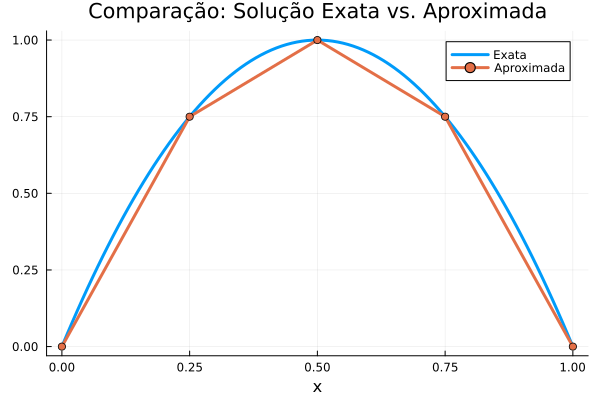

In [35]:
exemplo = 3
alfa, beta, f, u = dados_de_entrada(exemplo)
npg = 5
# Define o número de elementos em que o domínio [0,1] é dividido
ne = 4

# Define a matriz LG
LG = make_LG(ne)

# Define a dimensão do espaço aproximado Vₘ e o vetor EQ
m, EQ = make_EQ(ne)

# Define a matriz EQoLG
EQoLG = EQ[LG]

# Exibe os valores ne, LG, m, EQ e EQoLG
display("ne = "); display(ne)
display("LG = "); display(LG)
display("m = "); display(m)
display("EQ = "); display(EQ)
display("EQoLG = "); display(EQoLG)


# Constrói a matriz K e o vetor F
K = make_K(alfa, beta, ne, m, EQoLG)
F = make_F(f, ne, m, EQoLG, npg)

# Exibe a matriz K (sistema linear) e o vetor F (vetor força)
display("Matriz K:")
display(K)
display("Vetor F:")
display(F)

# Resolve o sistema linear K * c = F para obter os coeficientes solução aproximada u_h(x)
c = K \ F
display("Solução aproximada U:")
display(c)

# Exibe a solução exata nos nos internos da malha
display("Solução exata nos nós internos:")
h = 1.0 / ne  # Comprimento de cada elemento finito
display(u.(h:h:1-h))

# Define a discretização da malha com N nós internos, incluindo os pontos de fronteira
malha = 0:h:1

# Gera o gráfico comparando a solução aproximada com a solução exata
plt1 = plot(0:0.01:1, u.(0:0.01:1), label="Exata", lw=3, title="Comparação: Solução Exata vs. Aproximada")
plot!(plt1, malha, [0; c; 0], label="Aproximada", lw=3, linestyle=:solid, markershape=:circle) # O "!" adiciona ao gráfico existente
xlabel!("x")  # Adiciona o rótulo ao eixo x

# Exibe o gráfico final
display(plt1)

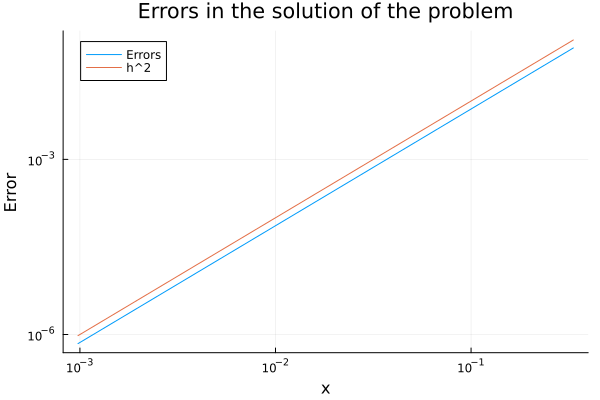

In [36]:
exemplo = 3
alfa, beta, f, u = dados_de_entrada(exemplo)

npg = 5

P, W = legendre(npg)

errors = zeros(9)
vec_h = zeros(9)

for p in 2:10
    ne = 2^p - 1
    h = 1.0 / ne
    vec_h[p-1] = h

    LG = make_LG(ne)
    m, EQ = make_EQ(ne)
    EQoLG = EQ[LG]

    K = make_K(alfa, beta, ne, m, EQoLG)
    F = make_F(f, ne, m, EQoLG, npg)

    c = K \ F

    errors[p-1] = calculate_error(c, u, X, fi_1, fi_2, P, W, npg, ne, h)
end

malha = 0:h:1

# Gera o gráfico comparando a solução aproximada com a solução exata
plt2 = Plots.plot(vec_h, errors, yscale=:log10, xscale=:log10, label="Errors", xlabel="h", ylabel="Error", title="Errors in the solution of the problem")
plot!(plt2, vec_h, vec_h.^2, yscale=:log10, xscale=:log10, legend=:topleft, label="h^2", xlabel="h", ylabel="Error")
xlabel!("x")  # Adiciona o rótulo ao eixo x

# Exibe o gráfico final
display(plt2)